# GANs For Art

## Importing the modules

In [ ]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
import IPython.display as display
import matplotlib as mpl
import numpy as np
from PIL import Image
import time
import functools

%matplotlib inline

#Load Drive

In [ ]:
try:
    from google.colab import drive

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    print("We're running Colab")
    # Mount the Google Drive at mount
    mount = '/content/gdrive'
    print("Colab: mounting Google drive on ", mount)
    drive.mount(mount)

    # Switch to the directory on the Google Drive that you want to use
    drive_root = mount + "/My Drive/Blockchain/dataset"

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
        print("\nColab: making sure ", drive_root, " exists.")
        os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    % cd $drive_root

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/My Drive/Blockchain/dataset  exists.

Colab: Changing directory to  /content/gdrive/My Drive/Blockchain/dataset
/content/gdrive/My Drive/Blockchain/dataset


## Preparing the data

In [ ]:
artists = pd.read_csv("artists.csv")

for i in artists['name']:
    print(i,end=" | ")

Amedeo Modigliani | Vasiliy Kandinskiy | Diego Rivera | Claude Monet | Rene Magritte | Salvador Dali | Edouard Manet | Andrei Rublev | Vincent van Gogh | Gustav Klimt | Hieronymus Bosch | Kazimir Malevich | Mikhail Vrubel | Pablo Picasso | Peter Paul Rubens | Pierre-Auguste Renoir | Francisco Goya | Frida Kahlo | El Greco | Albrecht Dürer | Alfred Sisley | Pieter Bruegel | Marc Chagall | Giotto di Bondone | Sandro Botticelli | Caravaggio | Leonardo da Vinci | Diego Velazquez | Henri Matisse | Jan van Eyck | Edgar Degas | Rembrandt | Titian | Henri de Toulouse-Lautrec | Gustave Courbet | Camille Pissarro | William Turner | Edvard Munch | Paul Cezanne | Eugene Delacroix | Henri Rousseau | Georges Seurat | Paul Klee | Piet Mondrian | Joan Miro | Andy Warhol | Paul Gauguin | Raphael | Michelangelo | Jackson Pollock | 

In [ ]:
batch_size = 128
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
#                                    transforms.RandomCrop(32, padding=2),
#                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root= drive_root + "/resized",
                                     transform=transform_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
print(len(train_ds))

8683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


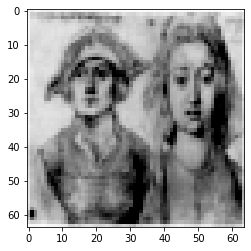

In [ ]:
images,_ = train_ds[382]
print(images.size())
plt.imshow(images.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


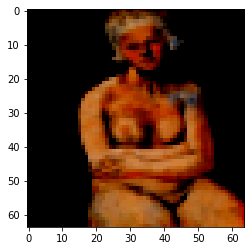

In [ ]:
images,_ = train_ds[4999]
plt.imshow(images.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


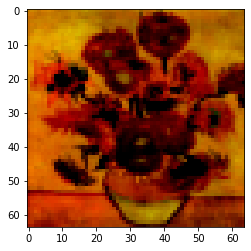

In [ ]:
images,_ = train_ds[8601]
plt.imshow(images.permute(1,2,0))

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

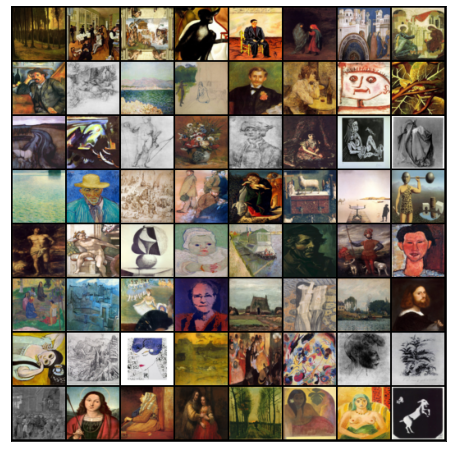

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 150

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

## Defining the model

torch.Size([128, 3, 64, 64])


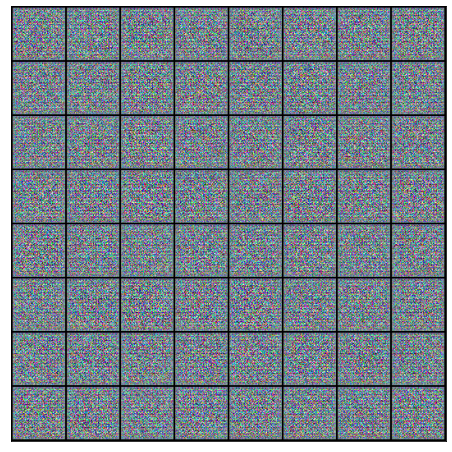

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
discriminator.load_state_dict(torch.load('checkpoints/D149.ckpt'))
generator.load_state_dict(torch.load('checkpoints/G149.ckpt'))

<All keys matched successfully>

In [ ]:
def fit(epochs, lr, start_idx=129):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
        name_check = epoch+128
    
        name = "checkpoints/G" + str(name_check) + '.ckpt'
        name_d = "checkpoints/D" + str(name_check) + '.ckpt'
        torch.save(generator.state_dict(), name)
        torch.save(discriminator.state_dict(), name_d)
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.001
epochs = 150

In [ ]:
history = fit(epochs,lr)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/150], loss_g: 3.3116, loss_d: 0.4396, real_score: 0.7706, fake_score: 0.0860
Saving generated-images-0129.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2/150], loss_g: 4.8478, loss_d: 0.2762, real_score: 0.8842, fake_score: 0.0972
Saving generated-images-0130.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3/150], loss_g: 15.4279, loss_d: 1.8100, real_score: 0.9990, fake_score: 0.6987
Saving generated-images-0131.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4/150], loss_g: 8.9305, loss_d: 0.4691, real_score: 0.9896, fake_score: 0.2573
Saving generated-images-0132.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [5/150], loss_g: 9.8552, loss_d: 0.8989, real_score: 0.9979, fake_score: 0.4341
Saving generated-images-0133.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [6/150], loss_g: 3.7771, loss_d: 0.3013, real_score: 0.8229, fake_score: 0.0446
Saving generated-images-0134.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [7/150], loss_g: 1.8912, loss_d: 0.4063, real_score: 0.7344, fake_score: 0.0370
Saving generated-images-0135.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [8/150], loss_g: 3.7932, loss_d: 1.1072, real_score: 0.5155, fake_score: 0.0007
Saving generated-images-0136.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [9/150], loss_g: 3.9902, loss_d: 0.5055, real_score: 0.8200, fake_score: 0.1797
Saving generated-images-0137.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [10/150], loss_g: 4.4420, loss_d: 0.4132, real_score: 0.7437, fake_score: 0.0041
Saving generated-images-0138.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [11/150], loss_g: 5.8234, loss_d: 0.2220, real_score: 0.9109, fake_score: 0.0925
Saving generated-images-0139.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [12/150], loss_g: 4.9123, loss_d: 0.1533, real_score: 0.9158, fake_score: 0.0514
Saving generated-images-0140.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [13/150], loss_g: 7.8754, loss_d: 0.3320, real_score: 0.9805, fake_score: 0.2208
Saving generated-images-0141.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [14/150], loss_g: 4.4550, loss_d: 0.1115, real_score: 0.9726, fake_score: 0.0712
Saving generated-images-0142.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [15/150], loss_g: 6.4701, loss_d: 0.9700, real_score: 0.9721, fake_score: 0.4359
Saving generated-images-0143.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [16/150], loss_g: 3.4616, loss_d: 0.6709, real_score: 0.7070, fake_score: 0.1195
Saving generated-images-0144.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [17/150], loss_g: 7.9462, loss_d: 0.4782, real_score: 0.9851, fake_score: 0.2874
Saving generated-images-0145.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [18/150], loss_g: 3.6300, loss_d: 0.7412, real_score: 0.7563, fake_score: 0.2327
Saving generated-images-0146.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [19/150], loss_g: 4.8538, loss_d: 0.2688, real_score: 0.8754, fake_score: 0.0536
Saving generated-images-0147.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [20/150], loss_g: 5.9624, loss_d: 0.1519, real_score: 0.9552, fake_score: 0.0874
Saving generated-images-0148.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [21/150], loss_g: 4.3363, loss_d: 0.1358, real_score: 0.9332, fake_score: 0.0547
Saving generated-images-0149.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [22/150], loss_g: 3.7289, loss_d: 0.2923, real_score: 0.9023, fake_score: 0.0881
Saving generated-images-0150.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [23/150], loss_g: 4.8487, loss_d: 0.4523, real_score: 0.9017, fake_score: 0.2270
Saving generated-images-0151.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [24/150], loss_g: 5.3885, loss_d: 0.2460, real_score: 0.8870, fake_score: 0.0895
Saving generated-images-0152.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [25/150], loss_g: 2.7401, loss_d: 0.4929, real_score: 0.7479, fake_score: 0.0989
Saving generated-images-0153.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [26/150], loss_g: 5.6874, loss_d: 0.2679, real_score: 0.9001, fake_score: 0.1118
Saving generated-images-0154.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [27/150], loss_g: 1.7804, loss_d: 8.5352, real_score: 0.0012, fake_score: 0.0000
Saving generated-images-0155.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [28/150], loss_g: 3.6870, loss_d: 0.4615, real_score: 0.8090, fake_score: 0.1619
Saving generated-images-0156.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [29/150], loss_g: 6.1324, loss_d: 0.5572, real_score: 0.8862, fake_score: 0.2406
Saving generated-images-0157.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [30/150], loss_g: 7.5394, loss_d: 0.4531, real_score: 0.9836, fake_score: 0.2825
Saving generated-images-0158.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [31/150], loss_g: 7.9403, loss_d: 0.3260, real_score: 0.9893, fake_score: 0.1732
Saving generated-images-0159.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [32/150], loss_g: 7.0120, loss_d: 0.1352, real_score: 0.9256, fake_score: 0.0344
Saving generated-images-0160.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [33/150], loss_g: 3.9930, loss_d: 0.1207, real_score: 0.9375, fake_score: 0.0436
Saving generated-images-0161.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [34/150], loss_g: 4.4112, loss_d: 0.1807, real_score: 0.8776, fake_score: 0.0313
Saving generated-images-0162.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [35/150], loss_g: 4.7604, loss_d: 0.1484, real_score: 0.9161, fake_score: 0.0498
Saving generated-images-0163.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [36/150], loss_g: 6.9130, loss_d: 0.1153, real_score: 0.9966, fake_score: 0.0865
Saving generated-images-0164.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [37/150], loss_g: 1.0171, loss_d: 0.7098, real_score: 0.6817, fake_score: 0.0398
Saving generated-images-0165.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [38/150], loss_g: 4.7618, loss_d: 0.3469, real_score: 0.8534, fake_score: 0.0794
Saving generated-images-0166.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [39/150], loss_g: 5.7785, loss_d: 0.4536, real_score: 0.8856, fake_score: 0.1794
Saving generated-images-0167.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [40/150], loss_g: 12.1124, loss_d: 0.8534, real_score: 0.9772, fake_score: 0.3826
Saving generated-images-0168.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [41/150], loss_g: 4.4477, loss_d: 0.1388, real_score: 0.9110, fake_score: 0.0326
Saving generated-images-0169.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [42/150], loss_g: 5.9201, loss_d: 0.1599, real_score: 0.9068, fake_score: 0.0411
Saving generated-images-0170.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [43/150], loss_g: 2.0159, loss_d: 0.4869, real_score: 0.6921, fake_score: 0.0239
Saving generated-images-0171.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [44/150], loss_g: 6.6573, loss_d: 0.1506, real_score: 0.9404, fake_score: 0.0634
Saving generated-images-0172.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [45/150], loss_g: 4.8759, loss_d: 0.1784, real_score: 0.8925, fake_score: 0.0399
Saving generated-images-0173.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [46/150], loss_g: 7.5978, loss_d: 0.1867, real_score: 0.9410, fake_score: 0.0872
Saving generated-images-0174.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [47/150], loss_g: 0.7422, loss_d: 0.6620, real_score: 0.6154, fake_score: 0.0200
Saving generated-images-0175.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [48/150], loss_g: 1.4861, loss_d: 0.9347, real_score: 0.5343, fake_score: 0.0131
Saving generated-images-0176.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [49/150], loss_g: 3.1133, loss_d: 0.3338, real_score: 0.8505, fake_score: 0.0791
Saving generated-images-0177.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [50/150], loss_g: 4.3830, loss_d: 0.2853, real_score: 0.8968, fake_score: 0.0463
Saving generated-images-0178.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [51/150], loss_g: 8.8057, loss_d: 0.2365, real_score: 0.9727, fake_score: 0.1394
Saving generated-images-0179.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [52/150], loss_g: 4.6657, loss_d: 0.1972, real_score: 0.8669, fake_score: 0.0180
Saving generated-images-0180.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [53/150], loss_g: 2.9859, loss_d: 0.4545, real_score: 0.7539, fake_score: 0.0400
Saving generated-images-0181.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [54/150], loss_g: 3.7356, loss_d: 0.4010, real_score: 0.7766, fake_score: 0.0075
Saving generated-images-0182.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [55/150], loss_g: 4.9092, loss_d: 0.2439, real_score: 0.8674, fake_score: 0.0540
Saving generated-images-0183.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [56/150], loss_g: 4.6396, loss_d: 0.1658, real_score: 0.9233, fake_score: 0.0617
Saving generated-images-0184.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [57/150], loss_g: 5.0609, loss_d: 0.1544, real_score: 0.9348, fake_score: 0.0620
Saving generated-images-0185.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [58/150], loss_g: 5.1327, loss_d: 0.1222, real_score: 0.9516, fake_score: 0.0584
Saving generated-images-0186.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [59/150], loss_g: 4.0529, loss_d: 0.1876, real_score: 0.9061, fake_score: 0.0477
Saving generated-images-0187.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [60/150], loss_g: 5.4087, loss_d: 0.1468, real_score: 0.8933, fake_score: 0.0192
Saving generated-images-0188.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [61/150], loss_g: 5.0964, loss_d: 0.1309, real_score: 0.9034, fake_score: 0.0089
Saving generated-images-0189.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [62/150], loss_g: 6.3554, loss_d: 0.0455, real_score: 0.9791, fake_score: 0.0225
Saving generated-images-0190.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [63/150], loss_g: 13.9998, loss_d: 4.9370, real_score: 0.9964, fake_score: 0.7716
Saving generated-images-0191.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [64/150], loss_g: 6.8498, loss_d: 0.1981, real_score: 0.9108, fake_score: 0.0744
Saving generated-images-0192.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [65/150], loss_g: 6.9930, loss_d: 0.1815, real_score: 0.9927, fake_score: 0.1335
Saving generated-images-0193.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [66/150], loss_g: 6.2748, loss_d: 0.1489, real_score: 0.9554, fake_score: 0.0543
Saving generated-images-0194.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [67/150], loss_g: 5.6948, loss_d: 0.3327, real_score: 0.9559, fake_score: 0.1697
Saving generated-images-0195.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [68/150], loss_g: 1.5301, loss_d: 0.5966, real_score: 0.6648, fake_score: 0.0110
Saving generated-images-0196.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [69/150], loss_g: 2.8028, loss_d: 0.4837, real_score: 0.7982, fake_score: 0.1127
Saving generated-images-0197.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [70/150], loss_g: 6.0862, loss_d: 0.2610, real_score: 0.8563, fake_score: 0.0139
Saving generated-images-0198.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [71/150], loss_g: 6.4608, loss_d: 0.0610, real_score: 0.9907, fake_score: 0.0403
Saving generated-images-0199.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [72/150], loss_g: 5.5845, loss_d: 0.2857, real_score: 0.8025, fake_score: 0.0259
Saving generated-images-0200.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [73/150], loss_g: 4.7631, loss_d: 0.1887, real_score: 0.9311, fake_score: 0.0832
Saving generated-images-0201.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [74/150], loss_g: 7.0870, loss_d: 0.0526, real_score: 0.9794, fake_score: 0.0274
Saving generated-images-0202.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [75/150], loss_g: 6.6318, loss_d: 0.0658, real_score: 0.9579, fake_score: 0.0192
Saving generated-images-0203.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 6.5814, loss_d: 0.1053, real_score: 0.9621, fake_score: 0.0498
Saving generated-images-0204.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 4.9134, loss_d: 0.0831, real_score: 0.9536, fake_score: 0.0190
Saving generated-images-0205.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 2.8223, loss_d: 0.3277, real_score: 0.7945, fake_score: 0.0093
Saving generated-images-0206.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 10.4254, loss_d: 0.7685, real_score: 0.9980, fake_score: 0.3073
Saving generated-images-0207.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 6.3442, loss_d: 0.2765, real_score: 0.9187, fake_score: 0.1012
Saving generated-images-0208.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 6.8982, loss_d: 0.1266, real_score: 0.9253, fake_score: 0.0272
Saving generated-images-0209.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 4.1159, loss_d: 0.2474, real_score: 0.8472, fake_score: 0.0144
Saving generated-images-0210.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 5.4347, loss_d: 0.0702, real_score: 0.9646, fake_score: 0.0288
Saving generated-images-0211.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 8.8821, loss_d: 0.2816, real_score: 0.9943, fake_score: 0.1902
Saving generated-images-0212.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 6.0659, loss_d: 0.0701, real_score: 0.9696, fake_score: 0.0319
Saving generated-images-0213.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 7.5247, loss_d: 0.1156, real_score: 0.9805, fake_score: 0.0806
Saving generated-images-0214.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 2.5980, loss_d: 0.2572, real_score: 0.8112, fake_score: 0.0179
Saving generated-images-0215.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 9.8122, loss_d: 0.7946, real_score: 0.9768, fake_score: 0.3502
Saving generated-images-0216.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 4.0265, loss_d: 0.4433, real_score: 0.8216, fake_score: 0.0985
Saving generated-images-0217.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 5.9518, loss_d: 0.2564, real_score: 0.8982, fake_score: 0.0670
Saving generated-images-0218.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 5.8260, loss_d: 0.2177, real_score: 0.9227, fake_score: 0.0687
Saving generated-images-0219.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 7.3191, loss_d: 0.3321, real_score: 0.9672, fake_score: 0.2023
Saving generated-images-0220.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 5.4059, loss_d: 0.0737, real_score: 0.9445, fake_score: 0.0136
Saving generated-images-0221.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 3.7273, loss_d: 0.1694, real_score: 0.8854, fake_score: 0.0289
Saving generated-images-0222.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 6.3317, loss_d: 0.1509, real_score: 0.9851, fake_score: 0.0999
Saving generated-images-0223.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 4.8780, loss_d: 0.1872, real_score: 0.9087, fake_score: 0.0465
Saving generated-images-0224.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 6.6229, loss_d: 0.0497, real_score: 0.9741, fake_score: 0.0218
Saving generated-images-0225.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 5.6567, loss_d: 0.1074, real_score: 0.9081, fake_score: 0.0041
Saving generated-images-0226.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 4.1538, loss_d: 0.2322, real_score: 0.8481, fake_score: 0.0076
Saving generated-images-0227.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 2.8863, loss_d: 0.7657, real_score: 0.6723, fake_score: 0.0626
Saving generated-images-0228.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 6.8862, loss_d: 0.1507, real_score: 0.9858, fake_score: 0.0970
Saving generated-images-0229.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 3.4324, loss_d: 0.2316, real_score: 0.8743, fake_score: 0.0286
Saving generated-images-0230.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 4.3136, loss_d: 0.3398, real_score: 0.8259, fake_score: 0.0318
Saving generated-images-0231.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 5.5189, loss_d: 0.1043, real_score: 0.9502, fake_score: 0.0388
Saving generated-images-0232.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 5.2529, loss_d: 0.1318, real_score: 0.8978, fake_score: 0.0114
Saving generated-images-0233.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 6.2819, loss_d: 0.0451, real_score: 0.9814, fake_score: 0.0244
Saving generated-images-0234.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 7.0096, loss_d: 0.0424, real_score: 0.9758, fake_score: 0.0166
Saving generated-images-0235.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 5.7258, loss_d: 0.0799, real_score: 0.9635, fake_score: 0.0345
Saving generated-images-0236.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 6.9653, loss_d: 0.0236, real_score: 0.9902, fake_score: 0.0127
Saving generated-images-0237.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 2.9888, loss_d: 0.2976, real_score: 0.8507, fake_score: 0.0280
Saving generated-images-0238.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 5.0136, loss_d: 0.2989, real_score: 0.8260, fake_score: 0.0154
Saving generated-images-0239.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 6.5054, loss_d: 0.0514, real_score: 0.9751, fake_score: 0.0164
Saving generated-images-0240.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 6.8366, loss_d: 0.0459, real_score: 0.9848, fake_score: 0.0281
Saving generated-images-0241.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 6.8476, loss_d: 0.0306, real_score: 0.9982, fake_score: 0.0268
Saving generated-images-0242.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 7.0714, loss_d: 0.0552, real_score: 0.9989, fake_score: 0.0476
Saving generated-images-0243.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 9.5439, loss_d: 0.0080, real_score: 0.9974, fake_score: 0.0053
Saving generated-images-0244.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 6.1713, loss_d: 0.7268, real_score: 0.7982, fake_score: 0.1519
Saving generated-images-0245.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 14.1298, loss_d: 1.8393, real_score: 0.9918, fake_score: 0.6102
Saving generated-images-0246.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 7.6425, loss_d: 0.1760, real_score: 0.9501, fake_score: 0.0739
Saving generated-images-0247.png


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 6.6833, loss_d: 0.1751, real_score: 0.9930, fake_score: 0.1252
Saving generated-images-0248.png


  0%|          | 0/40 [00:00<?, ?it/s]

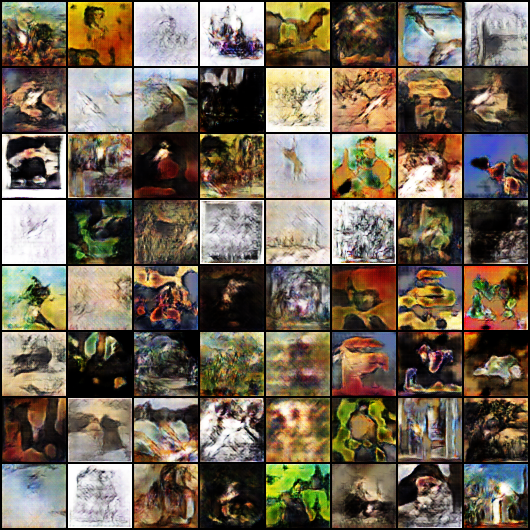

In [ ]:
from IPython.display import Image
Image(drive_root+"/generated/generated-images-0150.png")

In [ ]:
vid_fname = 'gans_training.avi'
sample_dir = drive_root + "/generated"
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 3, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

# Generate Images & Crop


In [ ]:
generator = to_device(generator, device)

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated_test'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
generator.load_state_dict(torch.load('checkpoints/G149.ckpt'))

<All keys matched successfully>

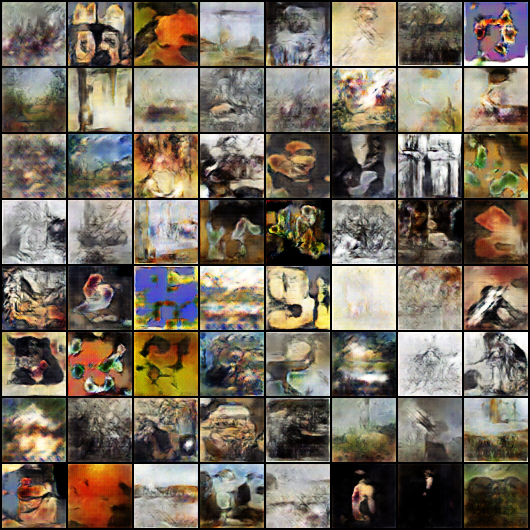

In [ ]:
save_samples(0, torch.randn(64, latent_size, 1, 1, device=device))

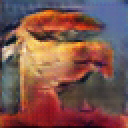

In [ ]:
from PIL import Image
margin = 2
image_size=64

img = Image.open(drive_root + "/generated/generated-images-0150.png")
i = random.randint(0,7)
j = random.randint(0,7)
pixel_raw = i*66 + margin
pixel_col = j*66 + margin
area = (pixel_raw,pixel_col, pixel_raw+image_size, pixel_col+image_size)
cropped_img = img.crop(area)
cropped_img = cropped_img.resize((128,128), resample=Image.BOX)

cropped_img.save(drive_root + "/crop.png")
from IPython.display import Image

Image(drive_root + "/crop.png")

# Neural style transfer

### Import and configure modules

In [ ]:
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

Import the sneakers image and choose a style image by cropping the generated image randomly

In [ ]:
content_path = drive_root + '/jj.jpg'
style_path = drive_root + "/crop.png"

## Visualize the input

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

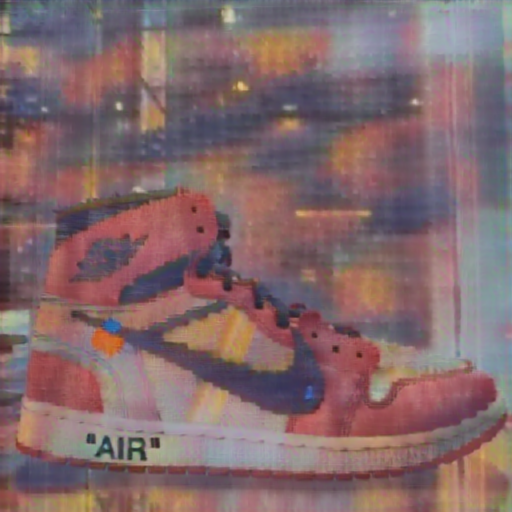

In [ ]:
import tensorflow_hub as hub
from PIL import Image

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)